# Previsão de Custos Médicos com Modelos de Regressão
Este notebook apresenta a construção e análise de modelos de regressão para prever os custos médicos individuais com base em dados de seguro de saúde.
Nesta primeira etapa estamos realizando a análise dos dados. Onde temos:
age: Idade do indivíduo.

**age:** idade;

**sex:** Sexo (male ou female);

**bmi:** Índice de massa corporal (Body Mass Index);

**children:** Número de filhos dependentes;

**smoker:** Se a pessoa é fumante (yes ou no);

**region:** Região dos EUA (southwest, southeast, northwest, northeast);

**charges:** Custo médico individual (alvo da previsão);

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import kagglehub

# Download latest version
path = kagglehub.dataset_download("mirichoi0218/insurance")

print("Path to dataset files:", path)

# Carregar os dados
df = pd.read_csv('/kaggle/input/insurance/insurance.csv')
df.head()

Path to dataset files: /kaggle/input/insurance


,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


## Exploração Inicial dos Dados

A seguir vamos explorar as características da base, como:

* Verificar o fomato da base;
* Verificar os tipos de dados e valores nulos;
* Verificar se há valores ausentes.

Na execução é possível verificar que não temos valores ausentes ou nulos.



In [12]:
# Verificar estrutura e valores ausentes
print(df.shape)
df.info()
df.isnull().sum()

#Verificar valores duplicados
duplicados = df.duplicated().sum()
print(f"\nNúmero de linhas duplicadas: {duplicados}")

(1338, 7)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB

Número de linhas duplicadas: 1


Removendo valores duplicados


In [13]:
# Removendo duplicados
df = df.drop_duplicates()

**Primeira pergunta:** Qual a relação entre o IMC e custos médico?


Correlação entre BMI e Charges: 0.20


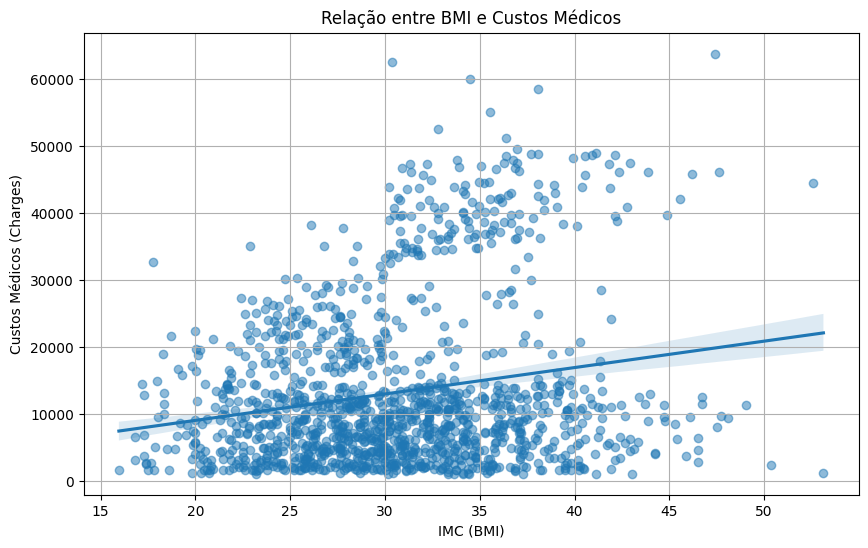

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# Verificando a correlação entre IMC e custos médicos
correlacao = df['bmi'].corr(df['charges'])
print(f"Correlação entre BMI e Charges: {correlacao:.2f}")

# Gráfico de dispersão com linha de regressão
plt.figure(figsize=(10, 6))
sns.regplot(x='bmi', y='charges', data=df, scatter_kws={'alpha':0.5})
plt.title('Relação entre BMI e Custos Médicos')
plt.xlabel('IMC (BMI)')
plt.ylabel('Custos Médicos (Charges)')
plt.grid(True)
plt.show()


Percebe-se que a relação é baixa o IMC sozinho não é um bom preditor de custos médicos

**Segunda pergunta:** O IMC influencia os custos médicos em fumantes e não fumantes?

Correlação (Fumantes): 0.81
Correlação (Não Fumantes): 0.08


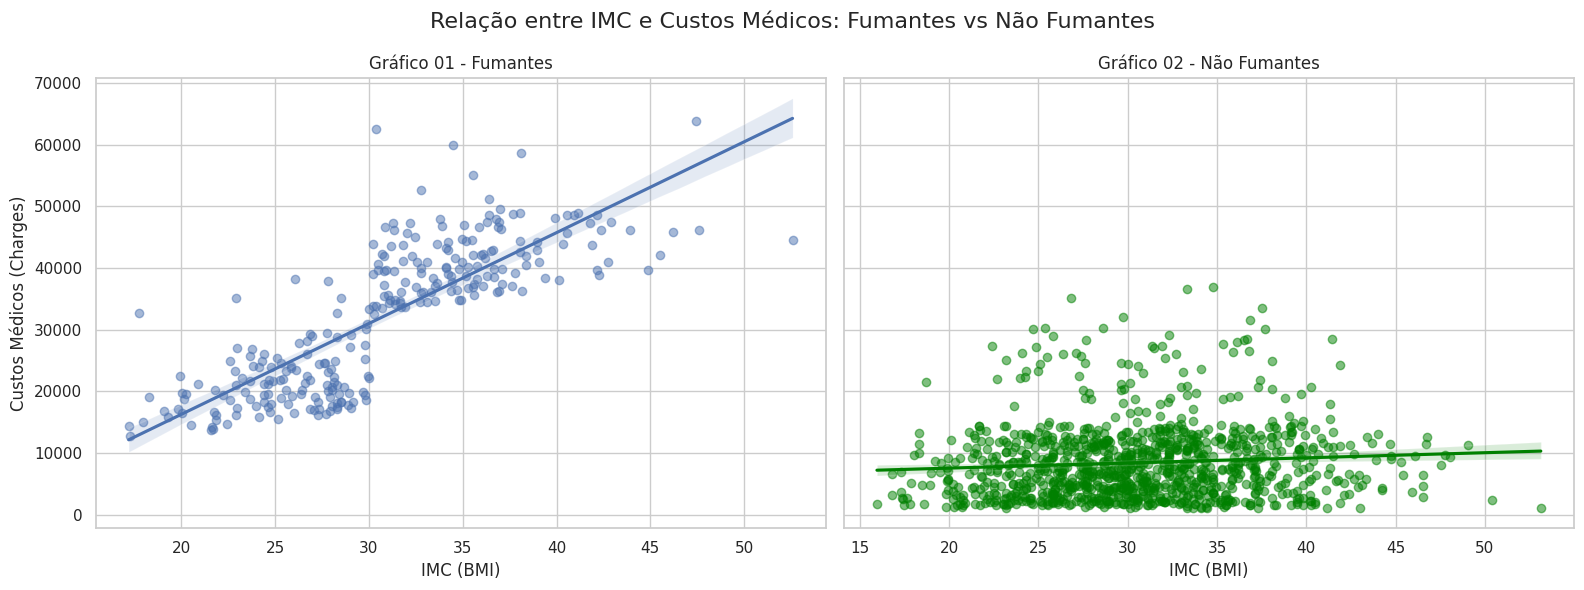

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# Configurando o estilo
sns.set(style="whitegrid")

# Criando subgráficos
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

# Separando os dados
fumantes = df[df['smoker'] == 'yes']
nao_fumantes = df[df['smoker'] == 'no']

# Plot para fumantes
sns.regplot(x='bmi', y='charges', data=fumantes, ax=axes[0], scatter_kws={'alpha':0.5})
axes[0].set_title('Gráfico 01 - Fumantes')
axes[0].set_xlabel('IMC (BMI)')
axes[0].set_ylabel('Custos Médicos (Charges)')

# Plot para não fumantes
sns.regplot(x='bmi', y='charges', data=nao_fumantes, ax=axes[1], scatter_kws={'alpha':0.5}, color='green')
axes[1].set_title('Gráfico 02 - Não Fumantes')
axes[1].set_xlabel('IMC (BMI)')
axes[1].set_ylabel('')

# Correlações
corr_fumantes = fumantes['bmi'].corr(fumantes['charges'])
corr_nao_fumantes = nao_fumantes['bmi'].corr(nao_fumantes['charges'])

# Exibir correlações
print(f"Correlação (Fumantes): {corr_fumantes:.2f}")
print(f"Correlação (Não Fumantes): {corr_nao_fumantes:.2f}")

plt.suptitle('Relação entre IMC e Custos Médicos: Fumantes vs Não Fumantes', fontsize=16)
plt.tight_layout()
plt.show()


Percebe-se que o IMC influência mais os custos quando pessoa é fumante, como pode ser observador no gráfico 1.

**Dados por região**

Na tabela a seguir é apresentado a quantidade de pessoas por região. Dessa forma entende-se a distribuição geográfica dos dados.


In [16]:
df["region"].value_counts()

,count
region,
southeast,364
southwest,325
northwest,324
northeast,324


**Tendências gerais dos dados**


A seguir são apresentados um resumo estatístico descritivos das colunas do dataFrame.


In [17]:
df.describe()

,age,bmi,children,charges
count,1337.000000,1337.000000,1337.000000,1337.000000
mean,39.222139,30.663452,1.095737,13279.121487
std,14.044333,6.100468,1.205571,12110.359656
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.290000,0.000000,4746.344000
50%,39.000000,30.400000,1.000000,9386.161300
75%,51.000000,34.700000,2.000000,16657.717450
max,64.000000,53.130000,5.000000,63770.428010


Apresentado os 10 primeiros registros com maior custo médico.


In [18]:
# Ordenando do maior para o menor custo médico
top_charges = df.sort_values(by='charges', ascending=False)

# Exibindo as 10 primeiras pessoas com maior custo
top_10 = top_charges.head(10)
print(top_10)


      age     sex     bmi  children smoker     region      charges
543    54  female  47.410         0    yes  southeast  63770.42801
1300   45    male  30.360         0    yes  southeast  62592.87309
1230   52    male  34.485         3    yes  northwest  60021.39897
577    31  female  38.095         1    yes  northeast  58571.07448
819    33  female  35.530         0    yes  northwest  55135.40209
1146   60    male  32.800         0    yes  southwest  52590.82939
34     28    male  36.400         1    yes  southwest  51194.55914
1241   64    male  36.960         2    yes  southeast  49577.66240
1062   59    male  41.140         1    yes  southeast  48970.24760
488    44  female  38.060         0    yes  southeast  48885.13561


Identificando os outliers, que representa os custos médicos.


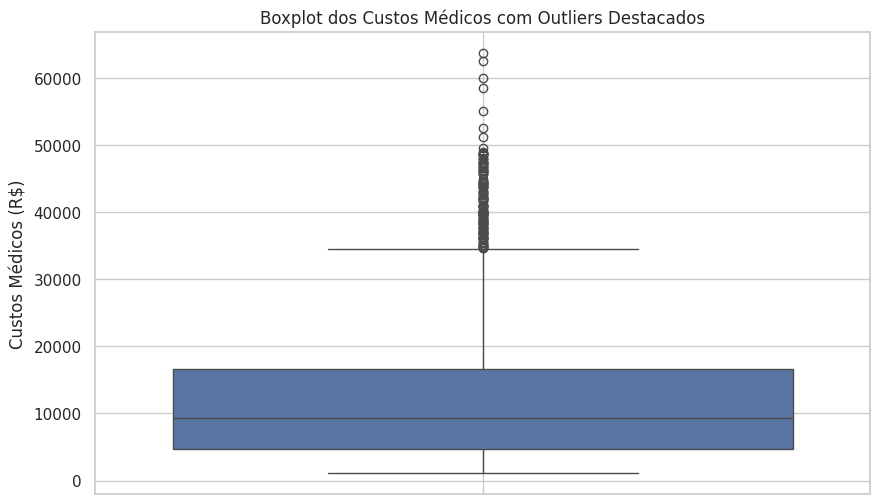

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

# Estilo visual
sns.set(style="whitegrid")

# Criando o boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(y='charges', data=df)

# Título e rótulos
plt.title('Boxplot dos Custos Médicos com Outliers Destacados')
plt.ylabel('Custos Médicos (R$)')
plt.grid(True)
plt.show()


## Estatísticas Descritivas e Visualizações

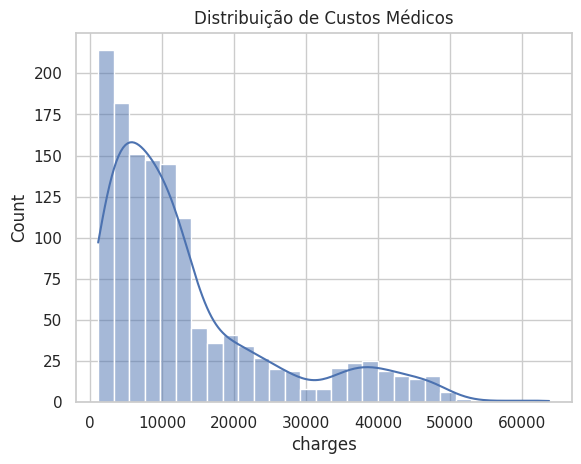

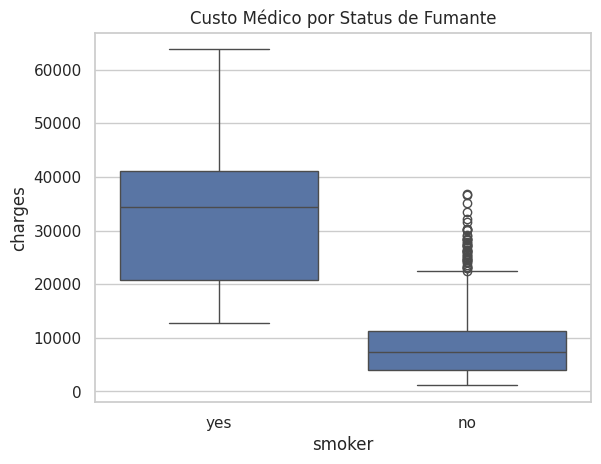

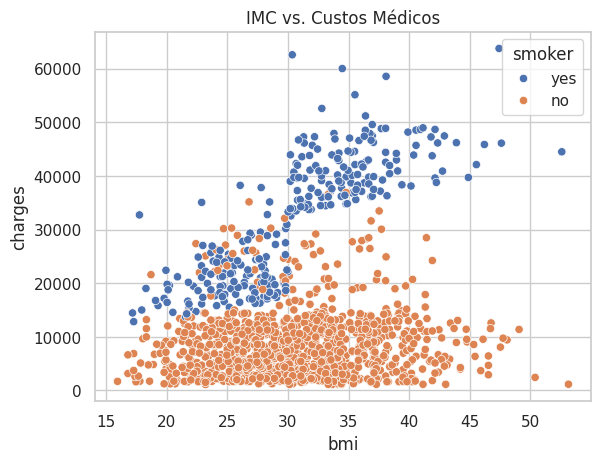

In [20]:

sns.histplot(df['charges'], kde=True)
plt.title('Distribuição de Custos Médicos')
plt.show()

sns.boxplot(x='smoker', y='charges', data=df)
plt.title('Custo Médico por Status de Fumante')
plt.show()

sns.scatterplot(x='bmi', y='charges', hue='smoker', data=df)
plt.title('IMC vs. Custos Médicos')
plt.show()

## Pré-processamento: Codificação de Variáveis Categóricas

Na base utilizada, apresenta-se 3 colunas categóricas:

- **sex:** male, female

- **smoker:** yes, no

- **region:** northeast, southeast, southwest, northwest

A seguir é utilizado a combinação entre Label Encoding que categoriza em 0 e 1, onde converte categorias de texto em números inteiros, aplicado no sexo e fumantes e one-hot encoding que cria uma nova categoria de coluna, onde será aplicado para as regiões.

In [21]:
from sklearn.preprocessing import LabelEncoder

# Codificar 'sex' e 'smoker' apenas se ainda forem strings
if df['sex'].dtype == 'object':
    le_sex = LabelEncoder()
    df['sex'] = le_sex.fit_transform(df['sex'])

if df['smoker'].dtype == 'object':
    le_smoker = LabelEncoder()
    df['smoker'] = le_smoker.fit_transform(df['smoker'])

# Codificar 'region' com get_dummies se ainda estiver presente
if 'region' in df.columns:
    df = pd.get_dummies(df, columns=['region'], drop_first=False)

df.head()



,age,sex,bmi,children,smoker,charges,region_northeast,region_northwest,region_southeast,region_southwest
0,19,0,27.900,0,1,16884.92400,False,False,False,True
1,18,1,33.770,1,0,1725.55230,False,False,True,False
2,28,1,33.000,3,0,4449.46200,False,False,True,False
3,33,1,22.705,0,0,21984.47061,False,True,False,False
4,32,1,28.880,0,0,3866.85520,False,True,False,False


## Divisão em Treino e Teste

Neste teste será separado 20% dos dados.


In [22]:
from sklearn.model_selection import train_test_split

X = df.drop('charges', axis=1)
y = df['charges']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f'Treino: {X_train.shape}, Teste: {X_test.shape}')

Treino: (1069, 9), Teste: (268, 9)


## Treinamento dos Modelos

**1º Modelo - Regressão Linear**

In [23]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Treinar o modelo
modelo = LinearRegression()
modelo.fit(X_train, y_train)

# Previsões
y_pred = modelo.predict(X_test)


MAE (Erro Absoluto Médio): R$ 4177.05
MSE (Erro Quadrático Médio): R$ 35478020.68
RMSE (Raiz do Erro Quadrático Médio): R$ 5956.34
R² (Coeficiente de Determinação): 0.8069


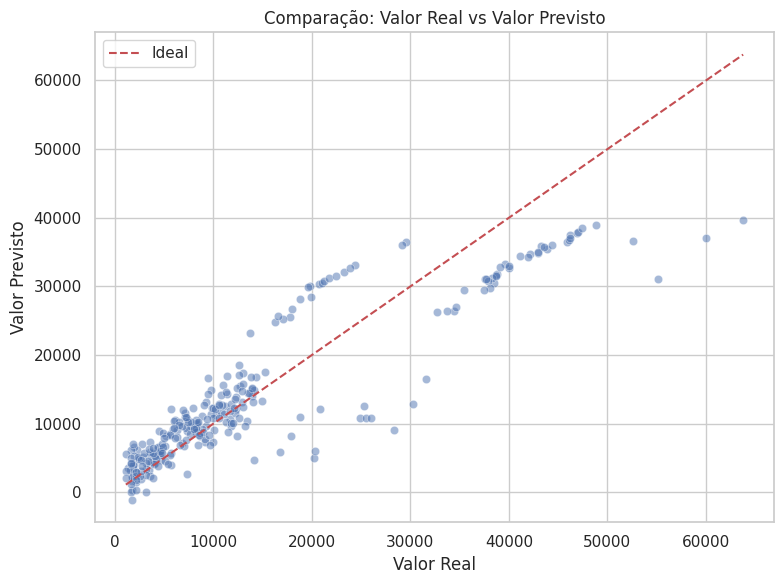

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

# Métricas
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)


print(f"MAE (Erro Absoluto Médio): R$ {mae:.2f}")
print(f"MSE (Erro Quadrático Médio): R$ {mse:.2f}")
print(f"RMSE (Raiz do Erro Quadrático Médio): R$ {rmse:.2f}")
print(f"R² (Coeficiente de Determinação): {r2:.4f}")

# Gráfico: Real vs Previsto
plt.figure(figsize=(8,6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', label='Ideal')
plt.xlabel('Valor Real')
plt.ylabel('Valor Previsto')
plt.title('Comparação: Valor Real vs Valor Previsto')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


**2º Modelo - Random Forest Regressor**






MAE (Random Forest): R$ 2557.55
RMSE (Random Forest): R$ 4623.98
R² (Random Forest): 0.8836


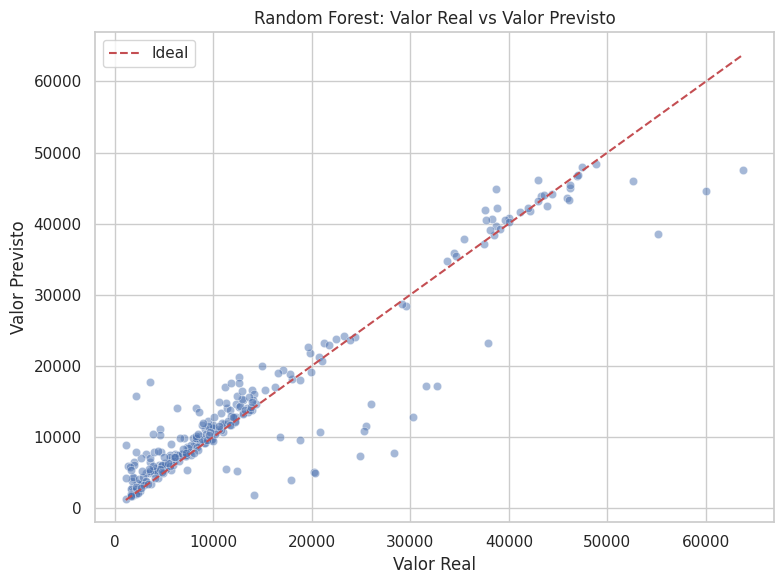

In [25]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Instanciando o modelo
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# 2. Treinando
rf_model.fit(X_train, y_train)

# 3. Fazendo previsões
y_pred_rf = rf_model.predict(X_test)

# 4. Avaliando
mae_rf = mean_absolute_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)

# 5. Exibindo os resultados
print(f"MAE (Random Forest): R$ {mae_rf:.2f}")
print(f"RMSE (Random Forest): R$ {rmse_rf:.2f}")
print(f"R² (Random Forest): {r2_rf:.4f}")

# 6. Gráfico comparativo
plt.figure(figsize=(8,6))
sns.scatterplot(x=y_test, y=y_pred_rf, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', label='Ideal')
plt.xlabel('Valor Real')
plt.ylabel('Valor Previsto')
plt.title('Random Forest: Valor Real vs Valor Previsto')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Importância das variáveis no Random Forest:

           Variável  Importância
4            smoker     0.600777
2               bmi     0.213360
0               age     0.136113
3          children     0.022901
1               sex     0.006898
6  region_northwest     0.005743
7  region_southeast     0.005391
5  region_northeast     0.004846
8  region_southwest     0.003972


<ipython-input-26-9f16f4e04f9b>:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importância', y='Variável', data=df_importancia, palette='viridis')


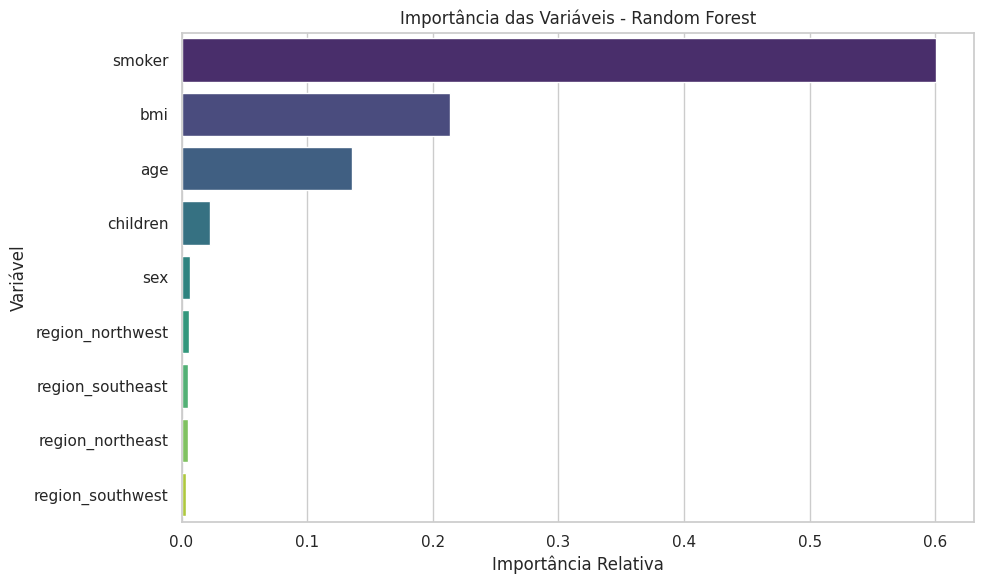

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Extraindo importâncias
importancias = rf_model.feature_importances_
variaveis = X_train.columns

# Criando DataFrame ordenado
df_importancia = pd.DataFrame({
    'Variável': variaveis,
    'Importância': importancias
}).sort_values(by='Importância', ascending=False)

# Exibindo tabela
print(df_importancia)

# Gráfico de barras
plt.figure(figsize=(10, 6))
sns.barplot(x='Importância', y='Variável', data=df_importancia, palette='viridis')
plt.title('Importância das Variáveis - Random Forest')
plt.xlabel('Importância Relativa')
plt.ylabel('Variável')
plt.tight_layout()
plt.show()


Observe que as variáveis Smoker, IMC, idade tem um peso e impactam bastante os custos médicos.

**3º Modelo - Árvore de decisão**





MAE (Decision Tree): R$ 2827.71
RMSE (Decision Tree): R$ 6134.25
R² (Decision Tree): 0.7952


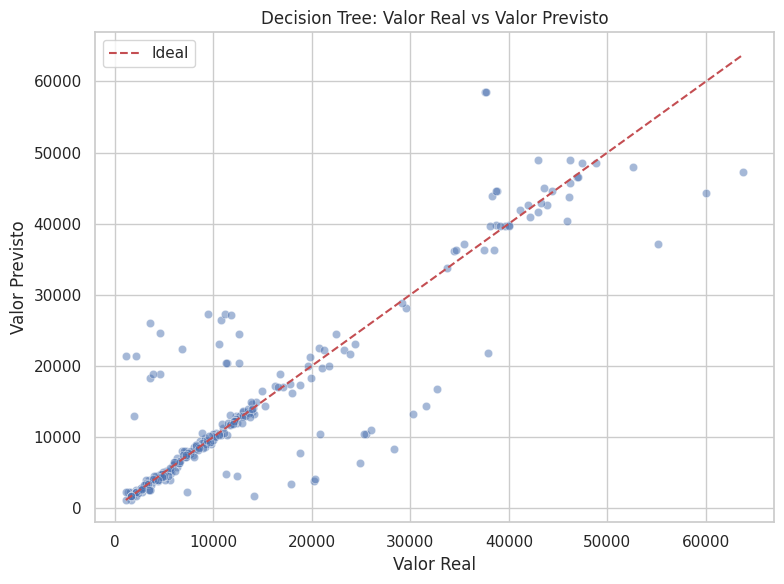

In [27]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Instanciando o modelo
dt_model = DecisionTreeRegressor(random_state=42)

# 2. Treinando o modelo
dt_model.fit(X_train, y_train)

# 3. Prevendo no conjunto de teste
y_pred_dt = dt_model.predict(X_test)

# 4. Avaliação
mae_dt = mean_absolute_error(y_test, y_pred_dt)
rmse_dt = np.sqrt(mean_squared_error(y_test, y_pred_dt))
r2_dt = r2_score(y_test, y_pred_dt)

# 5. Exibindo os resultados
print(f"MAE (Decision Tree): R$ {mae_dt:.2f}")
print(f"RMSE (Decision Tree): R$ {rmse_dt:.2f}")
print(f"R² (Decision Tree): {r2_dt:.4f}")

# 6. Gráfico: Valor Real vs Valor Previsto
plt.figure(figsize=(8,6))
sns.scatterplot(x=y_test, y=y_pred_dt, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', label='Ideal')
plt.xlabel('Valor Real')
plt.ylabel('Valor Previsto')
plt.title('Decision Tree: Valor Real vs Valor Previsto')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


**4º Modelo - XGBoost**


In [29]:
!pip install xgboost

MAE (XGBoost): R$ 2470.32
RMSE (XGBoost): R$ 4470.73
R² (XGBoost): 0.8912


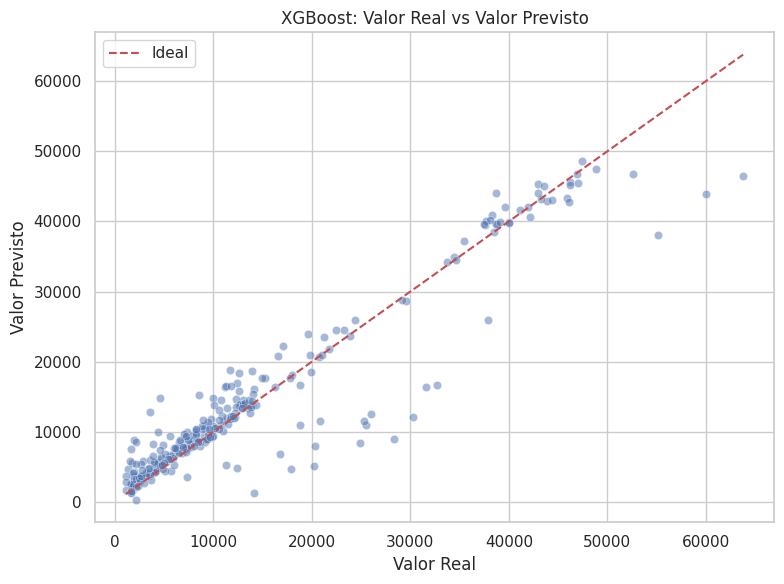

In [30]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Instanciando o modelo
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)

# 2. Treinando o modelo
xgb_model.fit(X_train, y_train)

# 3. Fazendo previsões
y_pred_xgb = xgb_model.predict(X_test)

# 4. Avaliando
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
r2_xgb = r2_score(y_test, y_pred_xgb)

# 5. Resultados
print(f"MAE (XGBoost): R$ {mae_xgb:.2f}")
print(f"RMSE (XGBoost): R$ {rmse_xgb:.2f}")
print(f"R² (XGBoost): {r2_xgb:.4f}")

# 6. Gráfico: Valor Real vs Valor Previsto
plt.figure(figsize=(8,6))
sns.scatterplot(x=y_test, y=y_pred_xgb, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', label='Ideal')
plt.xlabel('Valor Real')
plt.ylabel('Valor Previsto')
plt.title('XGBoost: Valor Real vs Valor Previsto')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Importância das variáveis XGBoost


           Variável  Importância
4            smoker     0.917231
2               bmi     0.027718
0               age     0.020761
5  region_northwest     0.010301
3          children     0.009582
7  region_southwest     0.005332
6  region_southeast     0.005311
1               sex     0.003764


<ipython-input-41-ad94a7aba80a>:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importância', y='Variável', data=df_importancia_xgb, palette='plasma')


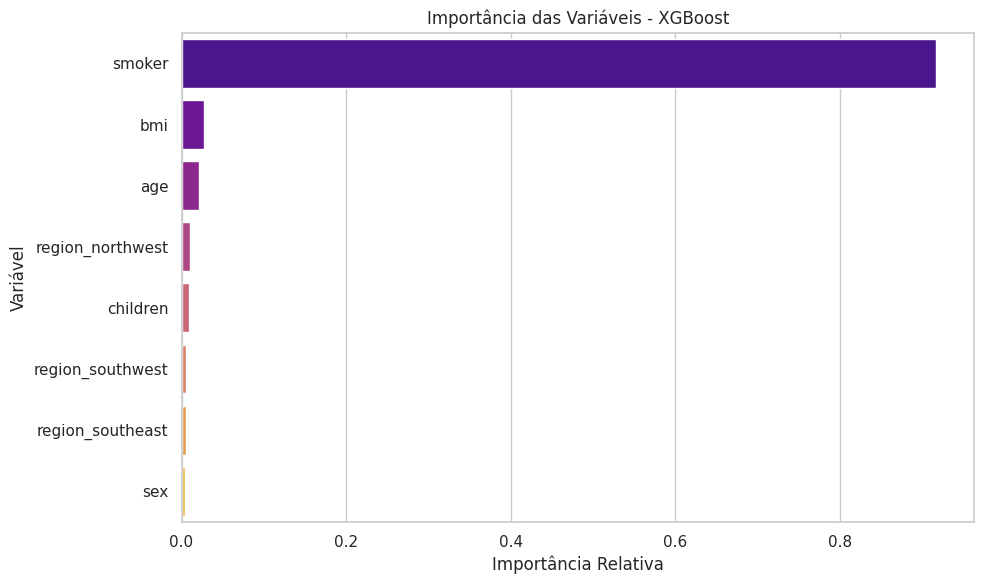

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Pegando as importâncias das features
importancias = xgb_model.feature_importances_
variaveis = X_train.columns

# 2. Criando DataFrame ordenado
df_importancia_xgb = pd.DataFrame({
    'Variável': variaveis,
    'Importância': importancias
}).sort_values(by='Importância', ascending=False)

# 3. Exibindo como tabela
print(df_importancia_xgb)

# 4. Plotando gráfico de barras
plt.figure(figsize=(10, 6))
sns.barplot(x='Importância', y='Variável', data=df_importancia_xgb, palette='plasma')
plt.title('Importância das Variáveis - XGBoost')
plt.xlabel('Importância Relativa')
plt.ylabel('Variável')
plt.tight_layout()
plt.show()


Bem similar ao random forest.


## Avaliação dos Modelos

              Modelo          MAE         RMSE        R²
0   Regressão Linear  4177.045561  5956.342894  0.806929
1  Árvore de Decisão  2827.707087  6134.251380  0.795223
2      Random Forest  2557.547607  4623.983742  0.883643
3            XGBoost  2470.322459  4470.731567  0.891228


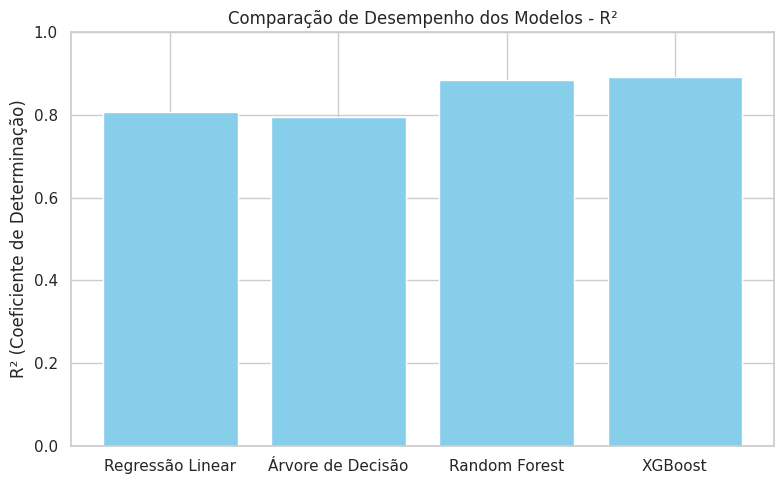

In [31]:
import pandas as pd
import matplotlib.pyplot as plt

# Substitua os valores abaixo pelos reais que você obteve em cada modelo:
comparacao = pd.DataFrame({
    'Modelo': ['Regressão Linear', 'Árvore de Decisão', 'Random Forest', 'XGBoost'],
    'MAE': [mae, mae_dt, mae_rf, mae_xgb],
    'RMSE': [rmse, rmse_dt, rmse_rf, rmse_xgb],
    'R²': [r2, r2_dt, r2_rf, r2_xgb]
})

# Exibindo a tabela
print(comparacao)

# Gráfico comparativo de R²
plt.figure(figsize=(8, 5))
plt.bar(comparacao['Modelo'], comparacao['R²'], color='skyblue')
plt.title('Comparação de Desempenho dos Modelos - R²')
plt.ylabel('R² (Coeficiente de Determinação)')
plt.ylim(0, 1)
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()


Os modelos XGBoost e Random Forest possuem o melhor resultado.

## Validação Estatística - Regressão Linear

Validando a eficácia do modelo.

                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.751
Model:                            OLS   Adj. R-squared:                  0.749
Method:                 Least Squares   F-statistic:                     500.0
Date:                Wed, 21 May 2025   Prob (F-statistic):               0.00
Time:                        01:32:43   Log-Likelihood:                -13538.
No. Observations:                1337   AIC:                         2.709e+04
Df Residuals:                    1328   BIC:                         2.714e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const            -1.194e+04    988.227  

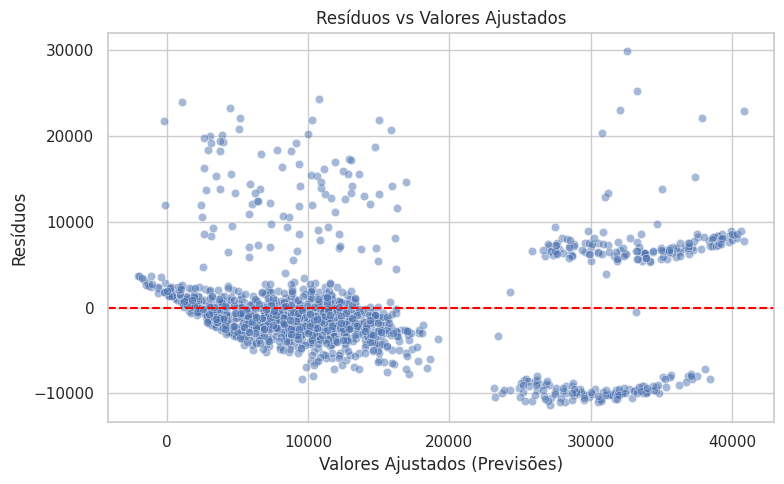


Teste de Breusch-Pagan para Heterocedasticidade:
LM Stat: 121.5712
LM p-value: 0.0000
F-Stat: 16.6039
F p-value: 0.0000


In [ ]:
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.compat import lzip

# 1. Garantir dados numéricos
X_clean = X.astype(float)
y_clean = y.astype(float)

# 2. Adiciona constante (intercepto)
X_sm = sm.add_constant(X_clean)

# 3. Ajusta o modelo OLS
modelo_ols = sm.OLS(y_clean, X_sm).fit()

# 4. Mostra resumo estatístico
print(modelo_ols.summary())

# 5. Verificação gráfica dos resíduos
residuos = modelo_ols.resid
valores_ajustados = modelo_ols.fittedvalues

plt.figure(figsize=(8, 5))
sns.scatterplot(x=valores_ajustados, y=residuos, alpha=0.5)
plt.axhline(0, linestyle='--', color='red')
plt.xlabel('Valores Ajustados (Previsões)')
plt.ylabel('Resíduos')
plt.title('Resíduos vs Valores Ajustados')
plt.grid(True)
plt.tight_layout()
plt.show()

# 6. Teste de heterocedasticidade (Breusch-Pagan)
bp_test = het_breuschpagan(residuos, X_sm)
labels = ['LM Stat', 'LM p-value', 'F-Stat', 'F p-value']
bp_result = dict(zip(labels, bp_test))
print("\nTeste de Breusch-Pagan para Heterocedasticidade:")
for k, v in bp_result.items():
    print(f"{k}: {v:.4f}")




## Visualização: Previsões vs Valores Reais

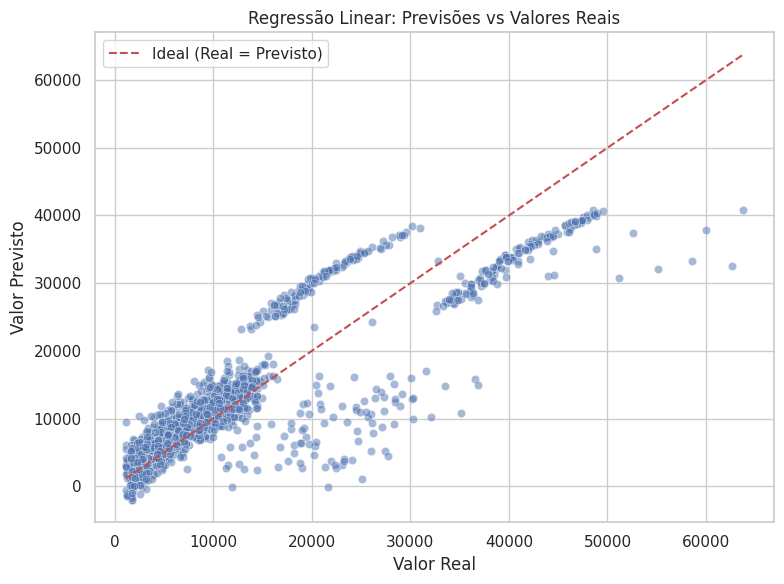

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Previsões do modelo (se ainda não fez)
y_pred = modelo_ols.predict(X_sm)

# Gráfico
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_clean, y=y_pred, alpha=0.5)
plt.plot([y_clean.min(), y_clean.max()], [y_clean.min(), y_clean.max()], '--r', label='Ideal (Real = Previsto)')
plt.xlabel('Valor Real')
plt.ylabel('Valor Previsto')
plt.title('Regressão Linear: Previsões vs Valores Reais')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


**Comparando os modelos**

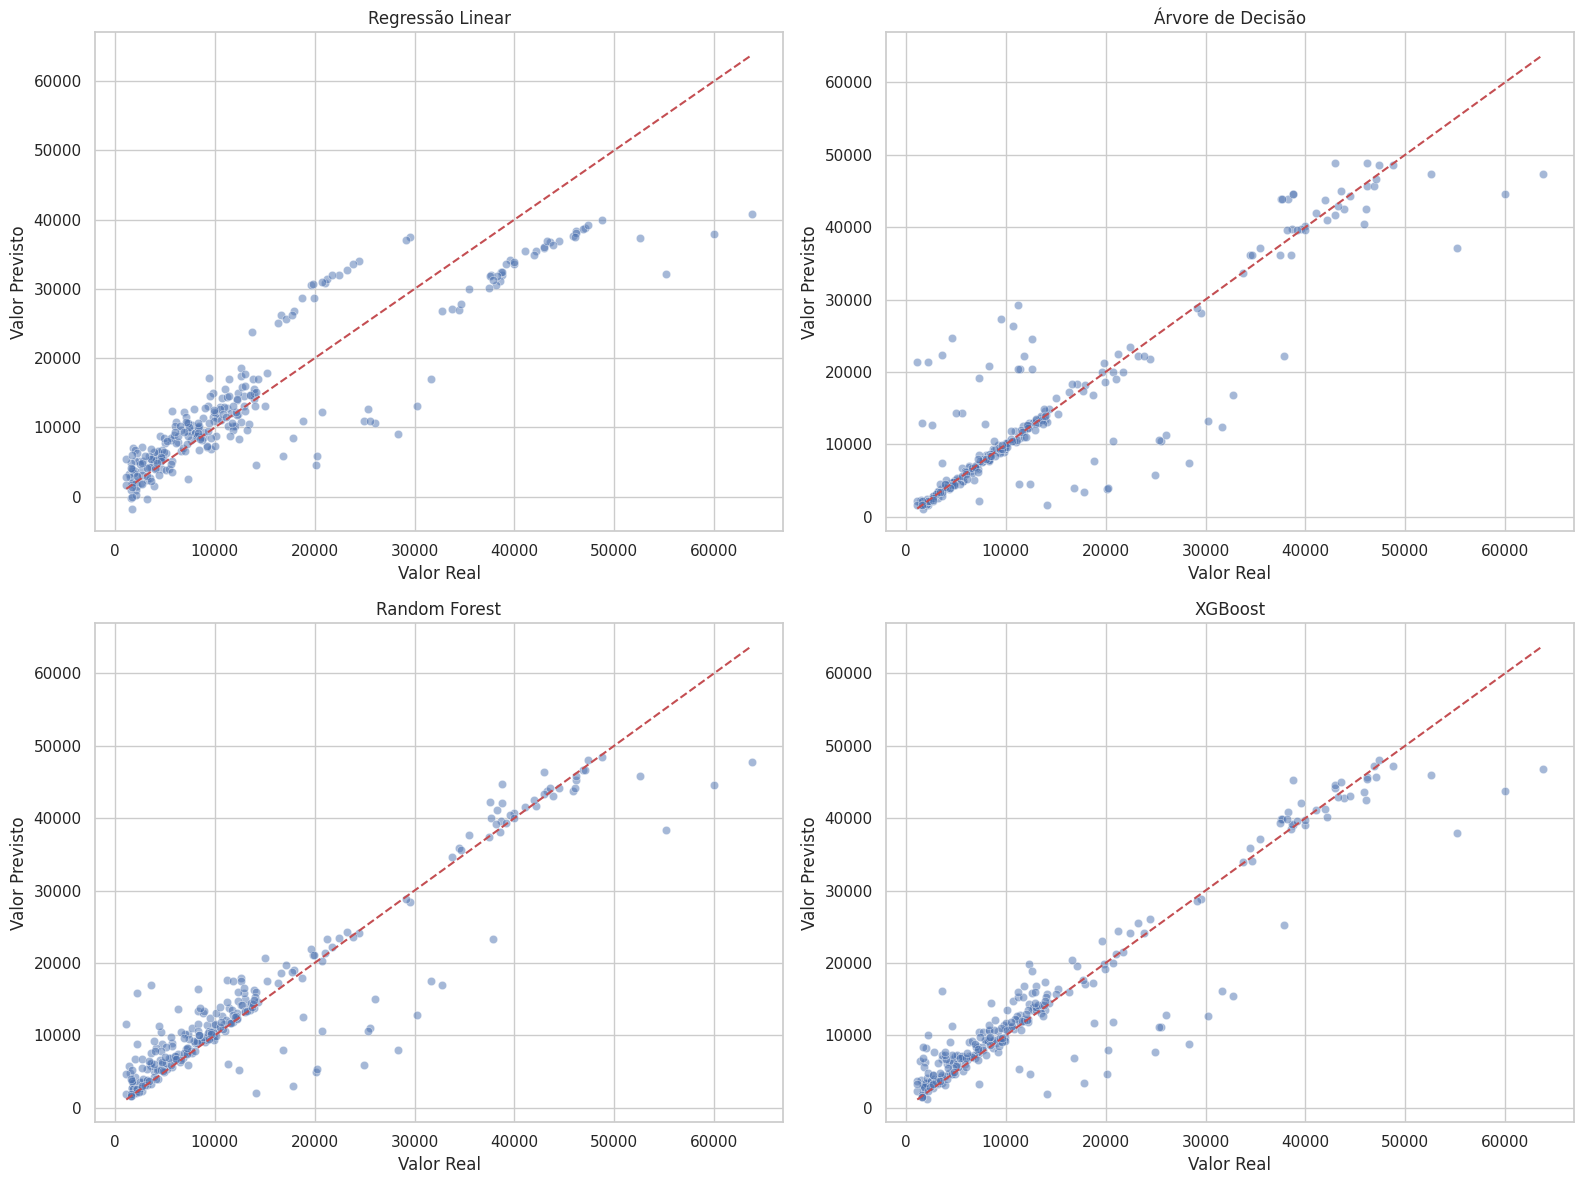

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Certifique-se de ter essas variáveis já preenchidas com os modelos:
# y_pred (Linear), y_pred_dt (Árvore), y_pred_rf (Random Forest), y_pred_xgb (XGBoost)

plt.figure(figsize=(16, 12))

# Gráfico 1 – Regressão Linear
plt.subplot(2, 2, 1)
sns.scatterplot(x=y_test, y=y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r')
plt.title('Regressão Linear')
plt.xlabel('Valor Real')
plt.ylabel('Valor Previsto')

# Gráfico 2 – Árvore de Decisão
plt.subplot(2, 2, 2)
sns.scatterplot(x=y_test, y=y_pred_dt, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r')
plt.title('Árvore de Decisão')
plt.xlabel('Valor Real')
plt.ylabel('Valor Previsto')

# Gráfico 3 – Random Forest
plt.subplot(2, 2, 3)
sns.scatterplot(x=y_test, y=y_pred_rf, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r')
plt.title('Random Forest')
plt.xlabel('Valor Real')
plt.ylabel('Valor Previsto')

# Gráfico 4 – XGBoost
plt.subplot(2, 2, 4)
sns.scatterplot(x=y_test, y=y_pred_xgb, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r')
plt.title('XGBoost')
plt.xlabel('Valor Real')
plt.ylabel('Valor Previsto')

plt.tight_layout()
plt.show()


## Conclusão

- Variáveis como `smoker`, `age` e `bmi` mostraram-se altamente significativas na previsão dos custos.
- O modelo **Random Forest e XGBoost** teve o melhor desempenho preditivo.
- A regressão linear foi útil para entender a influência estatística de cada variável.
- Visualizações confirmaram a boa performance dos modelos e aderência aos dados reais.

## Matriz de Correlação

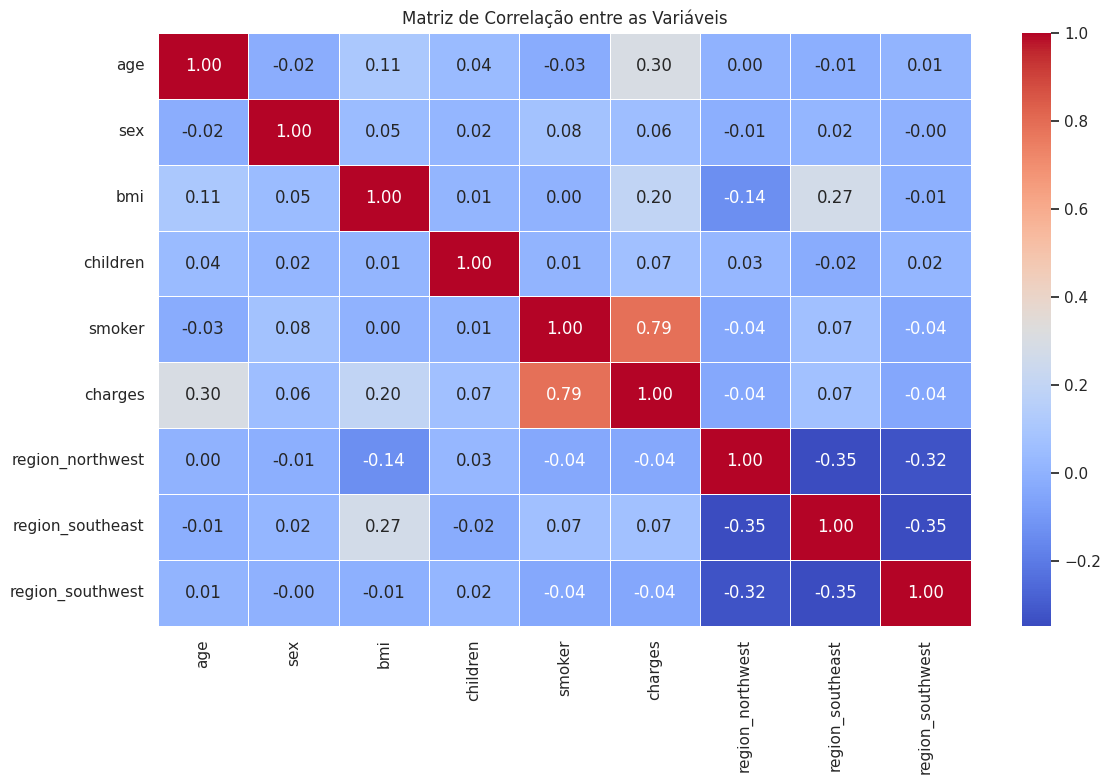

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calcula a correlação entre as colunas numéricas
correlation_matrix = df.corr(numeric_only=True)

# Plotando o heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)
plt.title('Matriz de Correlação entre as Variáveis')
plt.tight_layout()
plt.show()


Correlação com 'charges':
smoker              0.787234
age                 0.298308
bmi                 0.198401
region_southeast    0.073578
children            0.067389
sex                 0.058044
region_northwest   -0.038695
region_southwest   -0.043637
Name: charges, dtype: float64


<ipython-input-56-c82b984ea1cd>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=correlacoes_com_charges.values, y=correlacoes_com_charges.index, palette='coolwarm')


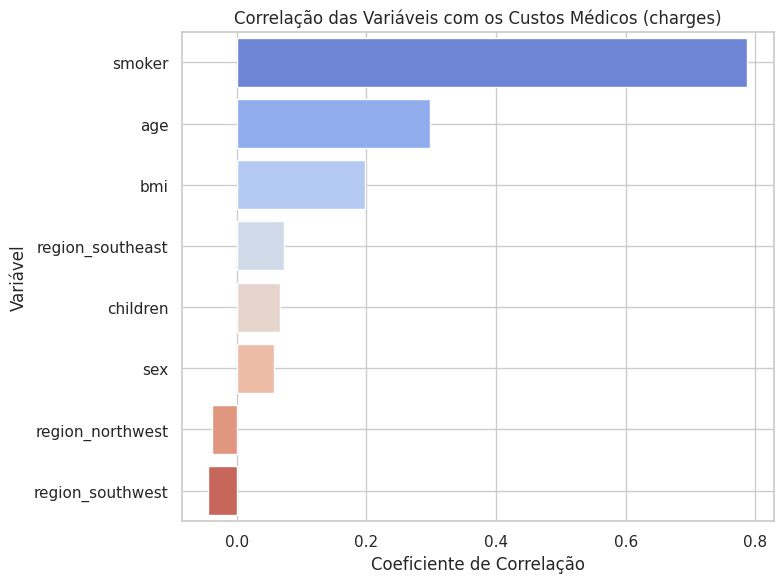

In [ ]:
# Calcula a matriz de correlação
correlacoes = df.corr(numeric_only=True)

# Seleciona somente a correlação com 'charges', ordenada
correlacoes_com_charges = correlacoes['charges'].drop('charges').sort_values(ascending=False)

# Exibe como tabela
print("Correlação com 'charges':")
print(correlacoes_com_charges)

# Visualização com gráfico de barras
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.barplot(x=correlacoes_com_charges.values, y=correlacoes_com_charges.index, palette='coolwarm')
plt.title("Correlação das Variáveis com os Custos Médicos (charges)")
plt.xlabel("Coeficiente de Correlação")
plt.ylabel("Variável")
plt.grid(True)
plt.tight_layout()
plt.show()


## Considerações Finais

Este projeto demonstrou o uso de diferentes técnicas de regressão para prever custos médicos individuais com base em características pessoais e hábitos de saúde.

- Modelos como Random Forest e XGBoost apresentaram melhor desempenho preditivo.
- A regressão linear forneceu boa interpretabilidade estatística.